In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
df = pd.read_csv('startup_success_data.csv')


In [38]:
df.head()

funding_rounds  total_funding  team_size  tech_stack_size   patents  \
0        2.635789  -6.259407e+06         18        -0.188664  1.432129   
1        0.468051  -6.372538e+06         -6         6.393478  3.758335   
2        1.853692  -3.723211e+06          8         1.655535  1.993431   
3        1.690547   2.298397e+06         -6         3.026151  2.402553   
4       -2.089758   2.712542e+06        -36         2.337657  3.370167   

   burned_rate  revenue_growth   market_size  competitors  social_media_score  \
0     0.623095       -1.625289 -3.286777e+06     0.181854           -0.005083   
1    -2.712422             NaN  9.778400e+04    -3.264116           -1.167660   
2     0.819204       -1.330146 -1.354409e+06     1.197189           -1.498869   
3     5.074848        2.071084 -2.371742e+06     0.446803            0.248394   
4    -4.097354        4.401355  3.225830e+06     1.007868           -0.094696   

   pivot_count  regulatory_score  client_retention  status  
0            1         57.916175         47.027075       2  
1            3         51.012632         72.810493       0  
2            0         12.772154         40.662497       1  
3            0         98.758329         42.734878       0  
4            3         65.968527         56.580872       2

In [39]:
missing_values = df.isnull().sum()
print("Valeurs manquantes par colonne :\n", missing_values)


Valeurs manquantes par colonne :
 funding_rounds          0
total_funding           0
team_size               0
tech_stack_size         0
patents                 0
burned_rate             0
revenue_growth        216
market_size             0
competitors             0
social_media_score      0
pivot_count             0
regulatory_score        0
client_retention      180
status                  0
dtype: int64


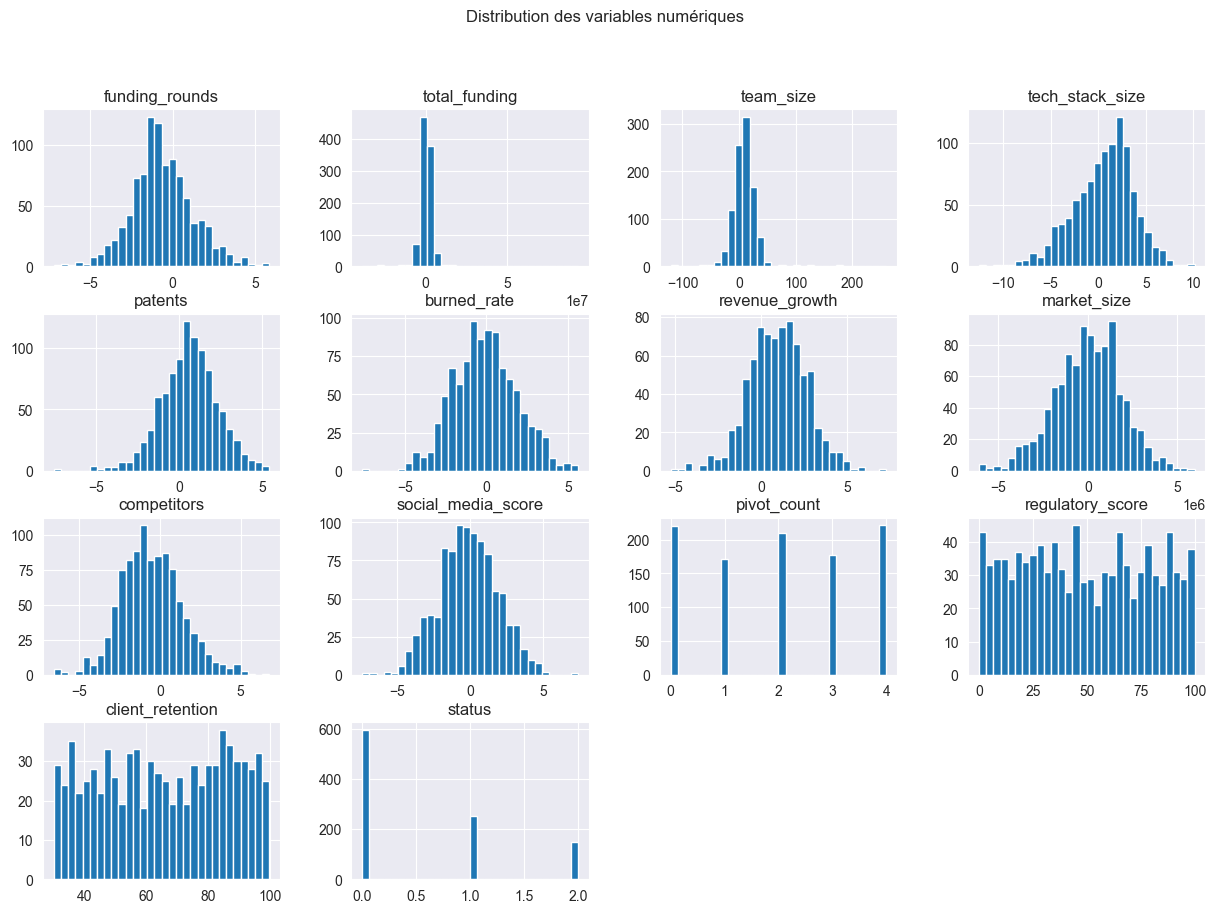

In [40]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution des variables numériques')
plt.show()

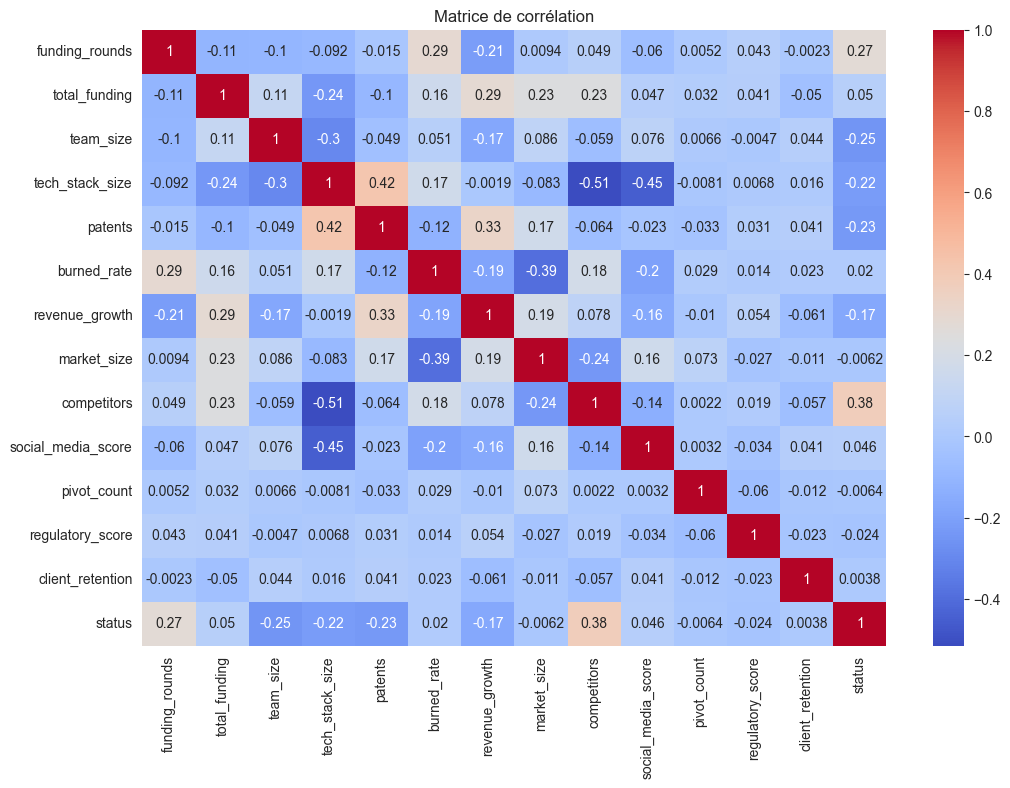

In [6]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

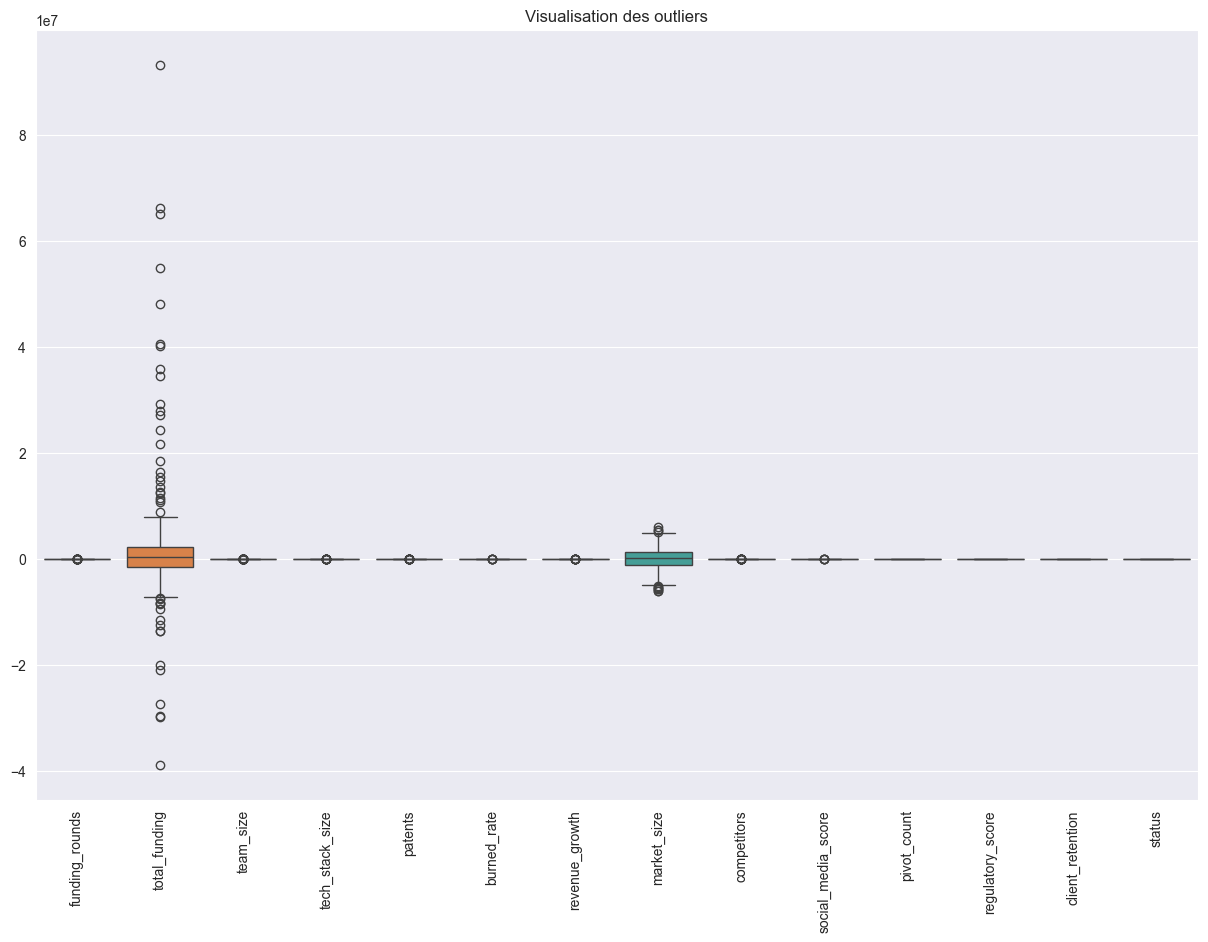

In [41]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.title('Visualisation des outliers')
plt.xticks(rotation=90)
plt.show()

<Figure size 1500x1000 with 0 Axes>

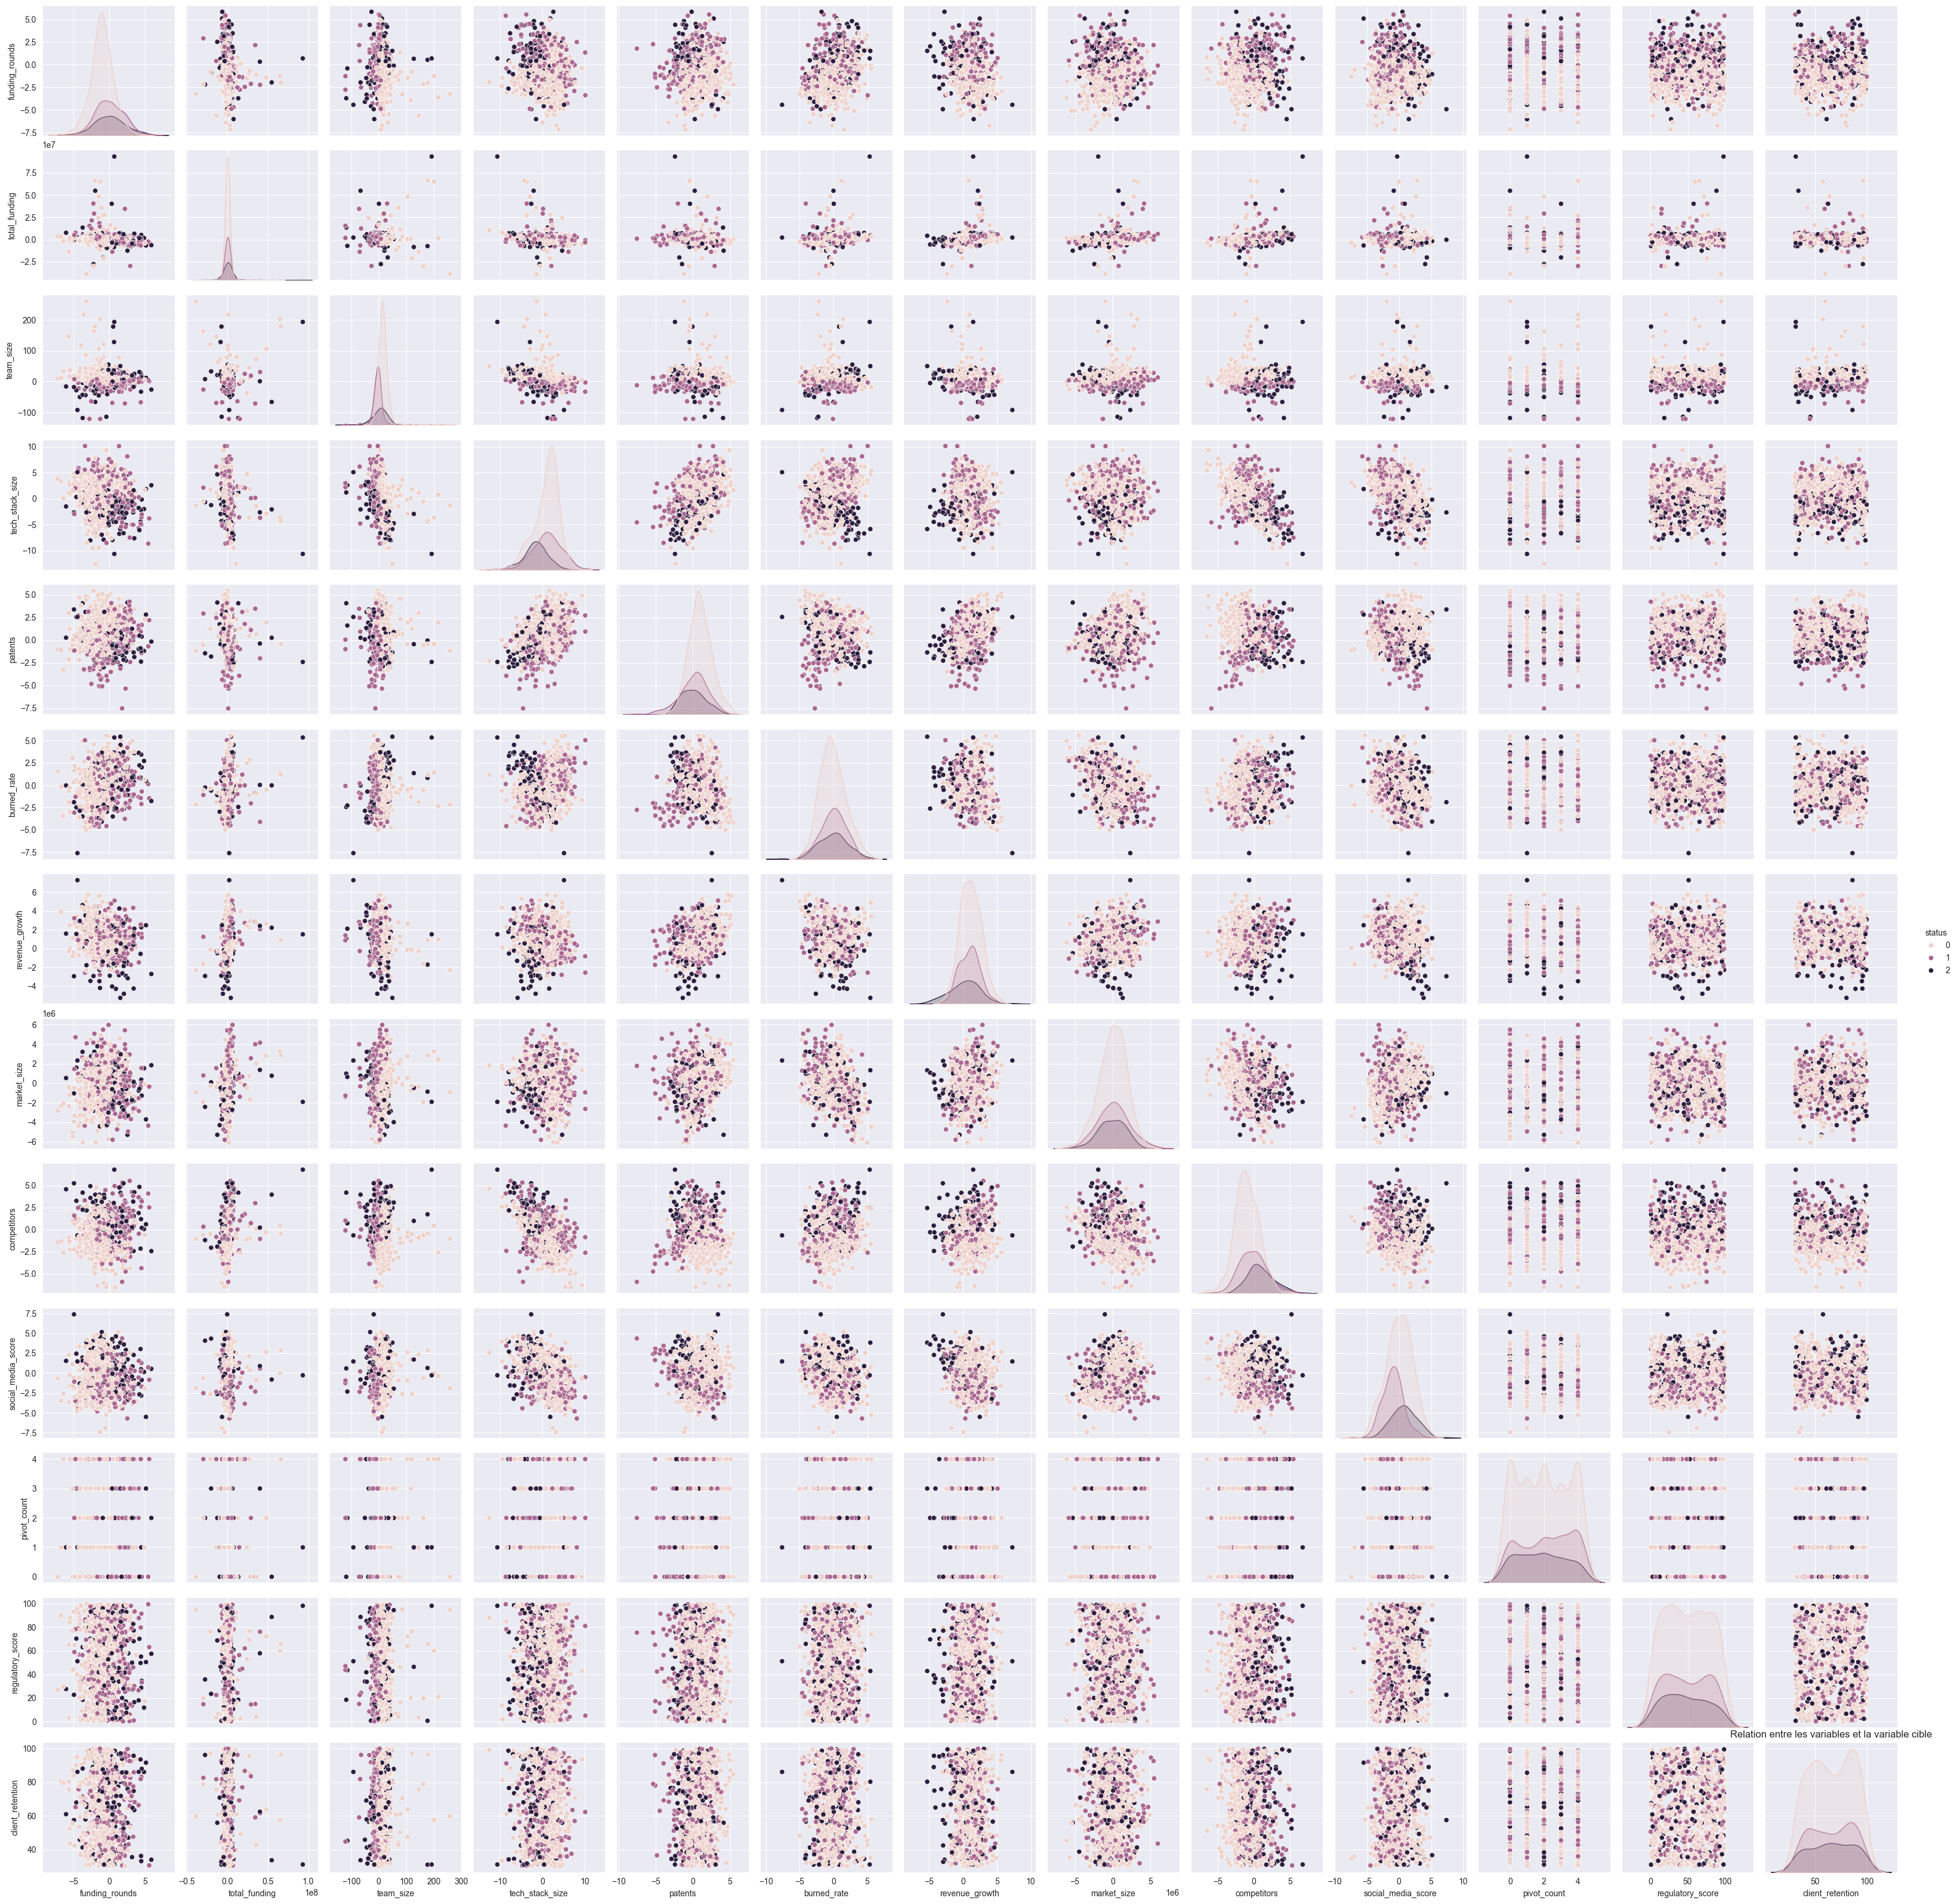

In [8]:
plt.figure(figsize=(15, 10))
sns.pairplot(df, hue='status')
plt.title('Relation entre les variables et la variable cible')
plt.show()

In [48]:
df["revenue_growth"]=df["revenue_growth"].fillna(df["revenue_growth"].mean())

In [49]:
df["client_retention"].isnull().sum()

np.int64(180)

In [50]:
df["client_retention"] = df["client_retention"].interpolate(method='linear')


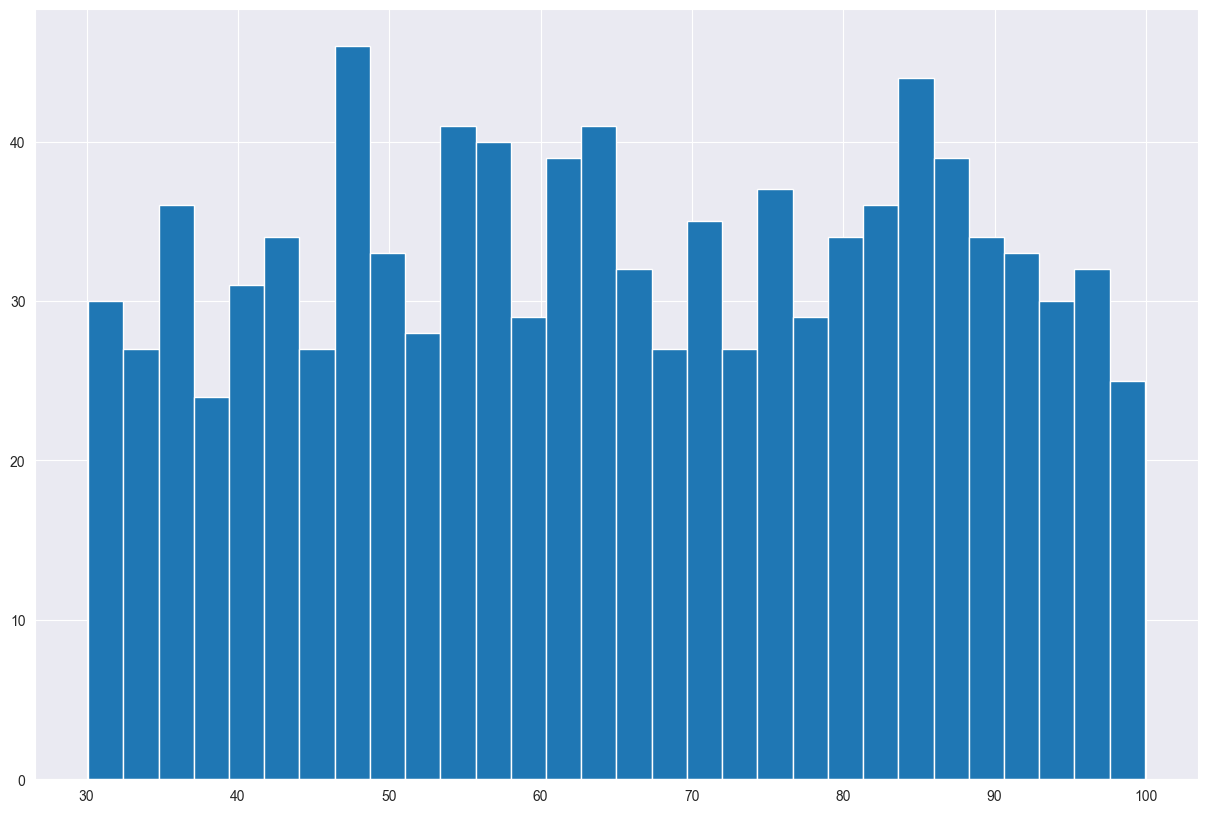

In [52]:
df["client_retention"].hist(bins=30, figsize=(15, 10))
plt.show()

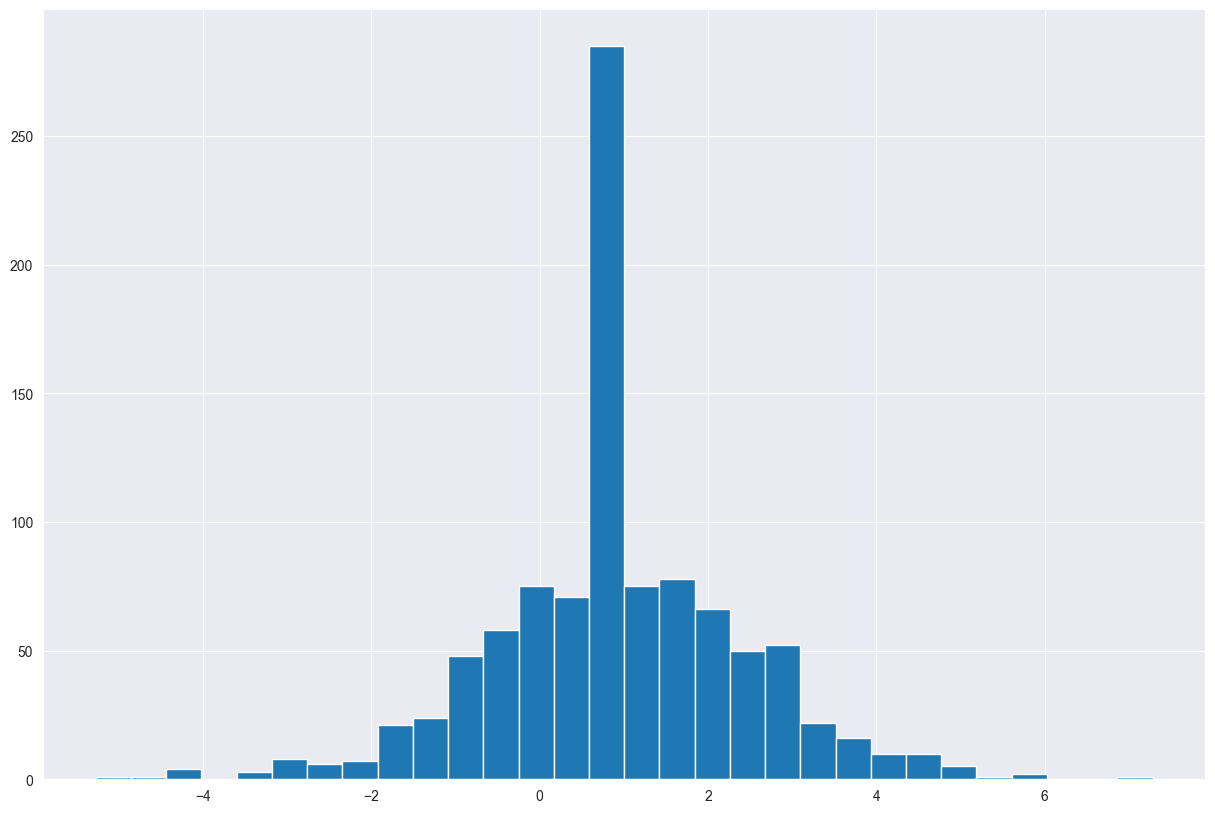

In [53]:
df["revenue_growth"].hist(bins=30, figsize=(15, 10))
plt.show()

In [54]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


In [55]:

numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
df = remove_outliers_iqr(df, numeric_columns)



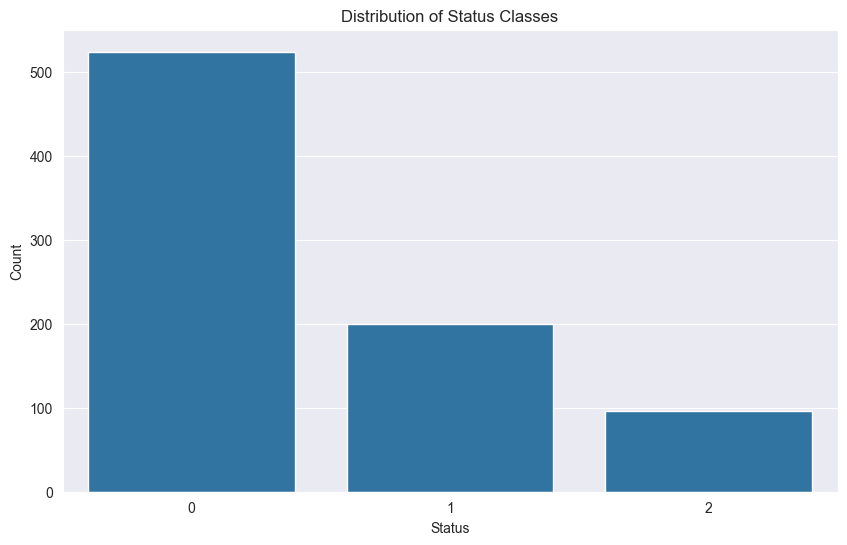

In [73]:
plt.figure(figsize=(10, 6))
sns.countplot(x='status', data=df)
plt.title('Distribution of Status Classes')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [79]:
from imblearn.over_sampling import SMOTE


In [86]:

X = df.drop("status", axis=1)
y = df["status"]



In [87]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [88]:
y_resampled.value_counts()

status
2    524
0    524
1    524
Name: count, dtype: int64

In [90]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from xgboost import XGBClassifier

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [94]:
rf=RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', verbose=1)
rf_grid.fit(X_train,y_train)

best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Meilleurs hyperparamètres Random Forest :", rf_grid.best_params_)
print("Accuracy Random Forest :", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs hyperparamètres Random Forest : {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy Random Forest : 0.9650793650793651
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       116
           1       0.96      0.96      0.96       106
           2       0.95      0.97      0.96        93

    accuracy                           0.97       315
   macro avg       0.96      0.97      0.96       315
weighted avg       0.97      0.97      0.97       315



In [95]:
from joblib import dump
dump(best_rf, 'best_rf_model.joblib')

['best_rf_model.joblib']

In [96]:
import xgboost as xgb
from xgboost import XGBClassifier

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_classes = len(y.unique())
params = {
    "objective": "multi:softmax",
    "num_class": num_classes,
    "max_depth": 10,
    "learning_rate": 0.1,
    "eval_metric": "mlogloss",
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    nfold=5,
    early_stopping_rounds=10,
    metrics="mlogloss",
    as_pandas=True,
    seed=42
)

best_num_boost_round = len(cv_results)
print("Nombre optimal de rounds :", best_num_boost_round)

final_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round
)

y_pred = final_model.predict(dtest)

# Évaluation des performances
print("Accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Nombre optimal de rounds : 149
Accuracy : 0.9619047619047619
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       116
           1       0.95      0.96      0.96       106
           2       0.94      0.97      0.95        93

    accuracy                           0.96       315
   macro avg       0.96      0.96      0.96       315
weighted avg       0.96      0.96      0.96       315



In [97]:
from joblib import dump
dump(final_model, 'xgfinal_model.joblib')

['xgfinal_model.joblib']